## Análisis de Datos Sociodemográficos.

Una de las interrogantes asociadas con el análisis de los datos sociodemográficos gira en torno a los factores que influyen en el nivel de ingreso de los habitantes de una ciudad.
Cada conjunto de datos contiene información demográfica y socioeconómica de personas que comprenden una comunidad o una ciudad tiene sus particularidades, y en función de dichas particularidades que incluyen atributos como edad, nivel educativo, ocupación, ingresos y tamaño del asentamiento y otros factores podemos indagar para encontrar factores que influyen en el ingreso de las personas en la comunidad o ciudad. En este caso particular, se plantea llevar a cabo un análisis exploratorio de datos para responder a las siguientes preguntas:

*Objetivo:*

   *¿Qué factores insiden en el nivel de ingreso de los habitantes de una ciudad?*

Para ello se plantean las siguientes hipótesis:

### Hipótesis sugeridas:
1. A mayor nivel educativo, mayores serán los ingresos de los participantes.
2. Las personas que viven en asentamientos grandes tienen mayores ingresos en promedio que las que viven en asentamientos pequeños.
3. Las personas casadas tienen mayores ingresos en promedio que las solteras.
4. La edad es un factor significativo para predecir los ingresos.
5. Hay diferencias significativas en los ingresos entre géneros para ciertas ocupaciones específicas.

Para empezar vamos a hacer una inspección preliminar de los datos.	

In [4]:
# ====================================
# Carga de librerías necesarias
# ====================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Carga de datos
data_df = pd.read_csv("sgdata.csv")

data_df.head()  # Muestra las primeras filas del DataFrame



,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,single,67,university,124670,skilled employee / official,2
1,100000002,1,non-single (divorced / separated / married / w...,22,high school,150773,skilled employee / official,2
2,100000003,0,single,49,high school,89210,unemployed / unskilled,0
3,100000004,0,single,45,high school,171565,skilled employee / official,1
4,100000005,0,single,53,high school,149031,skilled employee / official,1


In [6]:
# Revisión inical de los datos
print(data_df.info())
print('-------------------------------------------------------')
print('Descrición de los datos')
print(data_df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               2000 non-null   int64 
 1   Sex              2000 non-null   int64 
 2   Marital status   2000 non-null   object
 3   Age              2000 non-null   int64 
 4   Education        2000 non-null   object
 5   Income           2000 non-null   int64 
 6   Occupation       2000 non-null   object
 7   Settlement size  2000 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 125.1+ KB
None
-------------------------------------------------------
Descrición de los datos
                  ID          Sex Marital status          Age    Education  \
count   2.000000e+03  2000.000000           2000  2000.000000         2000   
unique           NaN          NaN              2          NaN            4   
top              NaN          NaN         single          NaN  high schoo

In [7]:
# Limpieza y preparación de los datos

# Creamos una copia del DataFrame original para trabajar con él
df = data_df.copy()
# Verificamos si hay filas con datos faltantes en variables relevantes
if df.isnull().sum().any():
    print("Hay datos faltantes en las siguientes columnas:")
    print(df.isnull().sum()[df.isnull().sum() > 0])
else:
    print("No hay datos faltantes en las columnas.") 

print('----------------------------------------------------------')

No hay datos faltantes en las columnas.
----------------------------------------------------------


In [8]:
# Renombramos las columnas para que sean más comprensibles
df.rename(columns={'Marital status': 'estado_civil', 
                   'Age': 'edad', 
                   'Education': 'educacion', 
                   'Occupation': 'ocupacion', 
                   'Income': 'ingresos',
                   'Settlement size': 'tamano_asentamiento'}, inplace=True)

# Recodificamos los valores de la variable 'Sexo'
df['sexo'] = df['Sex'].map({1: 'hombre', 
                            0 : 'mujer'})

# Recodificamos los valores de la variable 'Sexo'
df['educacion'] = df['educacion'].map({'university': 'universitario', 
                                       'high school': 'Secundaria', 
                                       'other / unknown': 'otro', 
                                       'graduate school': 'Postgrado'})

# Recodificamos los valores de la variable 'estado civil'
df['estado_civil'] = df['estado_civil'].replace({
    'single': 'soltero', 
    'non-single (divorced / separated / married / widowed)': 'no-soltero'
})

# Recodificamos los valores de la variable 'Ocupación'
df['ocupacion'] = df['ocupacion'].map({'skilled employee / official': 'Empleado cualificado/funcionario', 
                                       'unemployed / unskilled': 'Desempleado/no cualificado', 
                                       'management / self-employed / highly qualified employee / officer': 'directivo/autónomo/empleado/funcionario altamente cualificado'})

# Eliminamos la columna Sex
df=df.drop(columns=['Sex'])

df['estado_civil'] = df['estado_civil'].replace({
    'single': 'soltero', 
    'non-single (divorced / separated / married / widowed)': 'otro'
})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2000 non-null   int64 
 1   estado_civil         2000 non-null   object
 2   edad                 2000 non-null   int64 
 3   educacion            2000 non-null   object
 4   ingresos             2000 non-null   int64 
 5   ocupacion            2000 non-null   object
 6   tamano_asentamiento  2000 non-null   int64 
 7   sexo                 2000 non-null   object
dtypes: int64(4), object(4)
memory usage: 125.1+ KB


### Mostramos los primeros registros del DataFrame

A continuación mostramos los primeros registros del DataFrame relativos a las variables a considerar y su relación con los ingresos.

In [9]:
print(df['estado_civil'].value_counts())  # Descripción de la variable 
from tabulate import tabulate


df_grouped = df['ingresos'].groupby(df['estado_civil']).agg(['mean', 'std', 'count']).reset_index()
df_grouped.columns = ['estado_civil', 'Media de ingresos', 'Dev_Std ingresos', 'Cantidad']
print(tabulate(df_grouped, headers='keys', tablefmt='fancy_grid'))

estado_civil
soltero       1007
no-soltero     993
Name: count, dtype: int64
╒════╤════════════════╤═════════════════════╤════════════════════╤════════════╕
│    │ estado_civil   │   Media de ingresos │   Dev_Std ingresos │   Cantidad │
╞════╪════════════════╪═════════════════════╪════════════════════╪════════════╡
│  0 │ no-soltero     │              118133 │            36589.3 │        993 │
├────┼────────────────┼─────────────────────┼────────────────────┼────────────┤
│  1 │ soltero        │              123736 │            39370.7 │       1007 │
╘════╧════════════════╧═════════════════════╧════════════════════╧════════════╛


In [10]:
print(df['sexo'].value_counts())  # Descripción de la variable 
from tabulate import tabulate


df_grouped = df['ingresos'].groupby(df['sexo']).agg(['mean', 'std', 'count']).reset_index()
df_grouped.columns = ['sexo', 'Media de ingresos', 'Dev_Std ingresos', 'Cantidad']
print(tabulate(df_grouped, headers='keys', tablefmt='fancy_grid'))

sexo
mujer     1086
hombre     914
Name: count, dtype: int64
╒════╤════════╤═════════════════════╤════════════════════╤════════════╕
│    │ sexo   │   Media de ingresos │   Dev_Std ingresos │   Cantidad │
╞════╪════════╪═════════════════════╪════════════════════╪════════════╡
│  0 │ hombre │              112850 │            34266.3 │        914 │
├────┼────────┼─────────────────────┼────────────────────┼────────────┤
│  1 │ mujer  │              127775 │            39821.4 │       1086 │
╘════╧════════╧═════════════════════╧════════════════════╧════════════╛


In [11]:
print(df['ocupacion'].value_counts())  # Descripción de la variable 
from tabulate import tabulate


df_grouped = df['ingresos'].groupby(df['ocupacion']).agg(['mean', 'std', 'count']).reset_index()
df_grouped.columns = ['ocupacion', 'Media de ingresos', 'Dev_Std ingresos', 'Cantidad']
print(tabulate(df_grouped, headers='keys', tablefmt='fancy_grid'))

ocupacion
Empleado cualificado/funcionario                                 1113
Desempleado/no cualificado                                        633
directivo/autónomo/empleado/funcionario altamente cualificado     254
Name: count, dtype: int64
╒════╤═══════════════════════════════════════════════════════════════╤═════════════════════╤════════════════════╤════════════╕
│    │ ocupacion                                                     │   Media de ingresos │   Dev_Std ingresos │   Cantidad │
╞════╪═══════════════════════════════════════════════════════════════╪═════════════════════╪════════════════════╪════════════╡
│  0 │ Desempleado/no cualificado                                    │             90837.2 │            23943.5 │        633 │
├────┼───────────────────────────────────────────────────────────────┼─────────────────────┼────────────────────┼────────────┤
│  1 │ Empleado cualificado/funcionario                              │            125474   │            24745   │      

In [12]:
print(df['tamano_asentamiento'].value_counts())  # Descripción de la variable 
from tabulate import tabulate


df_grouped = df['ingresos'].groupby(df['tamano_asentamiento']).agg(['mean', 'std', 'count']).reset_index()
df_grouped.columns = ['tamano_asentamiento', 'Media de ingresos', 'Dev_Std ingresos', 'Cantidad']
print(tabulate(df_grouped, headers='keys', tablefmt='fancy_grid'))

tamano_asentamiento
0    989
1    544
2    467
Name: count, dtype: int64
╒════╤═══════════════════════╤═════════════════════╤════════════════════╤════════════╕
│    │   tamano_asentamiento │   Media de ingresos │   Dev_Std ingresos │   Cantidad │
╞════╪═══════════════════════╪═════════════════════╪════════════════════╪════════════╡
│  0 │                     0 │              101062 │            26505.9 │        989 │
├────┼───────────────────────┼─────────────────────┼────────────────────┼────────────┤
│  1 │                     1 │              137430 │            34579.1 │        544 │
├────┼───────────────────────┼─────────────────────┼────────────────────┼────────────┤
│  2 │                     2 │              143890 │            40781.3 │        467 │
╘════╧═══════════════════════╧═════════════════════╧════════════════════╧════════════╛


In [13]:
print(df['educacion'].value_counts())  # Descripción de la variable 
from tabulate import tabulate


df_grouped = df['ingresos'].groupby(df['educacion']).agg(['mean', 'std', 'count']).reset_index()
df_grouped.columns = ['educacion', 'Media de ingresos', 'Dev_Std ingresos', 'Cantidad']
print(tabulate(df_grouped, headers='keys', tablefmt='fancy_grid'))


educacion
Secundaria       1386
universitario     291
otro              287
Postgrado          36
Name: count, dtype: int64
╒════╤═══════════════╤═════════════════════╤════════════════════╤════════════╕
│    │ educacion     │   Media de ingresos │   Dev_Std ingresos │   Cantidad │
╞════╪═══════════════╪═════════════════════╪════════════════════╪════════════╡
│  0 │ Postgrado     │              146818 │            37635.7 │         36 │
├────┼───────────────┼─────────────────────┼────────────────────┼────────────┤
│  1 │ Secundaria    │              116368 │            32636.6 │       1386 │
├────┼───────────────┼─────────────────────┼────────────────────┼────────────┤
│  2 │ otro          │              115068 │            40058.8 │        287 │
├────┼───────────────┼─────────────────────┼────────────────────┼────────────┤
│  3 │ universitario │              145406 │            48501.6 │        291 │
╘════╧═══════════════╧═════════════════════╧════════════════════╧════════════╛


### Gráficos de Distribución de las variables continuas

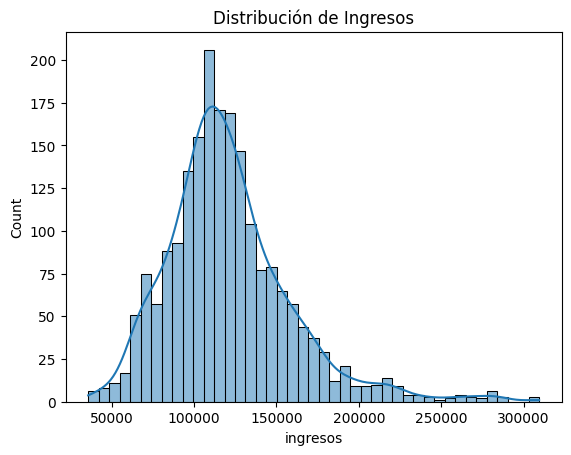

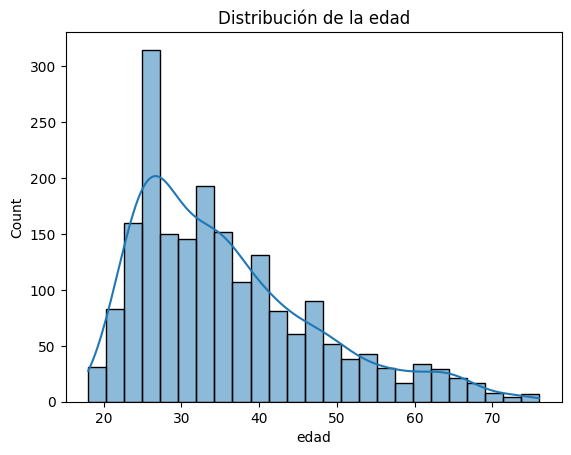

In [14]:
# Histograma y Densidad de la variable ingresos
sns.histplot(df['ingresos'], kde=True)
plt.title('Distribución de Ingresos')
plt.show()

# Histograma y Densidad de la variable edad
sns.histplot(df['edad'], kde=True)
plt.title('Distribución de la edad')
plt.show()

Para las variables ***ingresos*** y ***edad*** se aprecian distribuciones con asimetría, ambas positivas. Esto implica que hay valores más separados de la media a la derecha, lo cual se traduce en ingresos altos con menor probabilidad, y lo mismo para la edad. 

Nos disponemos a analizar los datos para dar respuesta a la pregunta planteada a partir de las hipótesis.

- **Hipótesis 1:** A mayor nivel educativo, mayores serán los ingresos de los participantes.
Variables: educacion (categórica) vs. ingresos (numérica).
Análisis sugerido: ANOVA de un factor + boxplot por nivel educativo.

- **Hipótesis 2:** Las personas que viven en asentamientos grandes tienen mayores ingresos en promedio que las que viven en asentamientos pequeños.
Variables: tamano_asentamiento (ordinal, 0, 1, 2) vs. ingresos.
Análisis sugerido: Comparación de medias (ANOVA o Kruskal-Wallis si hay problemas de normalidad) + gráfica.

- **Hipótesis 3:** Las personas no-solteras tienen mayores ingresos en promedio que las solteras.
Variables: estado_civil  vs. ingresos.
Análisis sugerido: Test t de Student para muestras independientes.

- **Hipótesis 4:** La edad es un factor significativo para predecir los ingresos.
Análisis sugerido: Regresión lineal.

- **Hipótesis 5:** Hay diferencias significativas en los ingresos entre géneros para ciertas ocupaciones específicas.
Variables: Sexo, ocupacion, ingresos.
Análisis sugerido: ANOVA de dos factores o análisis estratificado por ocupación + pruebas t para diferencias de género.

### HIPÓTESIS 1
 Un nivel educativo más alto conlleva a mayores ingresos.

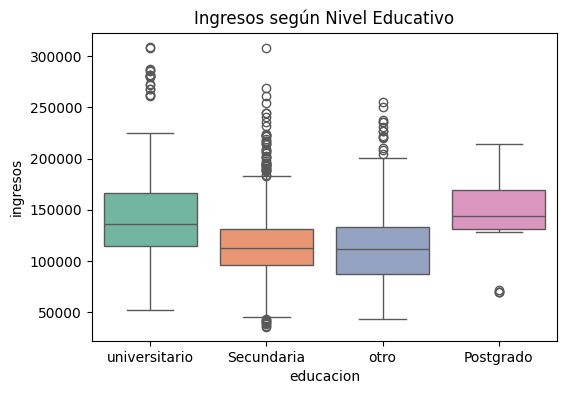

In [15]:
# Boxplot educación vs ingresos
plt.figure(figsize=(6,4))
sns.boxplot(x='educacion', y='ingresos', data=df, palette='Set2')
plt.title('Ingresos según Nivel Educativo')
plt.show()



Los gráficos de caja muestran la distribución de los ingresos según el nivel educativo.Se oberva mayores ingresos de acuerdo a las medianas en los niveles educativos más altos, sin embargo, es necesario una prueba estadística para corroborar este hecho. Llevaremos a cabo un anova usando la técnica de Kruskal-Wallis para determinar si hay diferencias significativas entre los niveles educativos y sus ingresos. El suo de la prueba de Kruskal-Wallis en parte se debe a que con esta prueba no-paramétrica evitamos probar la homogeneidad de la varianza y la distribución de probabilidad de los grupos.

In [16]:
# ANOVA
anova_educacion = stats.kruskal(
    *[group['ingresos'].values for name, group in df.groupby('educacion')]
)

anova_educacion_df = pd.DataFrame({
    'F-statistic': anova_educacion.statistic,
    'p-value': anova_educacion.pvalue
}, index=['ANOVA'])

anova_educacion_df['Significativo'] = anova_educacion_df['p-value'] < 0.05
anova_educacion_df['Significativo'] = anova_educacion_df['Significativo'].replace({True: 'Sí', False: 'No'})
print(anova_educacion_df)

if anova_educacion_df['Significativo'].values[0] == 'Sí':
    print("Se rechaza la hipótesis nula: hay diferencias significativas entre los niveles educativos y sus ingresos.")
else:
    print("No se rechaza la hipótesis nula: no hay diferencias significativas entre los niveles educativos y sus ingresos.")

       F-statistic       p-value Significativo
ANOVA   142.115128  1.322442e-30            Sí
Se rechaza la hipótesis nula: hay diferencias significativas entre los niveles educativos y sus ingresos.


Como se concluye a traves del codigo en python. Hay evidencia estadística de diferencias entre los niveles educativos y sus ingresos. La pregunta es, cuales de ellos es diferente o si son todos diferentes. 


Para determinar cuál de los grupos es el que difiere de los demás, se llevan a cabo las *Pruebas post hoc* después de realizar el ANOVA. Una de las pruebas post hoc comunes es la ***prueba de Tukey***. Esta prueba compara todas las combinaciones posibles de pares de poblaciones y determina si hay diferencias significativas entre ellas.

In [17]:
# Comparación de medias con Tukey HSD
pg.pairwise_tukey(data=df, dv='ingresos', between='educacion').round(3)

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Postgrado,Secundaria,146818.333,116367.720,30450.613,6169.676,4.936,0.000,0.929
1,Postgrado,otro,146818.333,115068.213,31750.121,6461.814,4.913,0.000,0.796
2,Postgrado,universitario,146818.333,145405.983,1412.351,6456.862,0.219,0.996,0.030
3,Secundaria,otro,116367.720,115068.213,1299.508,2370.123,0.548,0.947,0.038
4,Secundaria,universitario,116367.720,145405.983,-29038.263,2356.589,-12.322,0.000,-0.809
5,otro,universitario,115068.213,145405.983,-30337.770,3040.338,-9.978,0.000,-0.681


### CONCLUSIÓN DE HIPOTESIS 1:
*El nivel educativo tiene un efecto estadísticamente significativo sobre los ingresos.*

*Al observar la prueba de Tukey, podemos ver que los grupos que muestran un p-valor significativo son Universitario y Postgrado. Esto respalda la hipótesis: a mayor educación, mayores ingresos.

### HIPÓTESIS 2
El Tamaño del asentamiento es un factor que influye en el ingreso

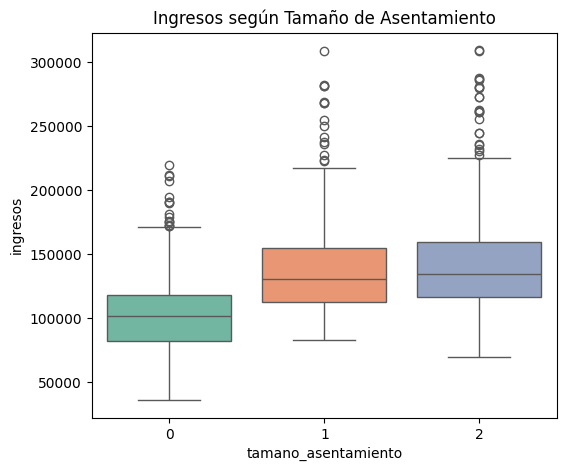

In [18]:
# Boxplot tamaño asentamiento vs ingresos
plt.figure(figsize=(6,5))
sns.boxplot(x='tamano_asentamiento', y='ingresos', data=df, palette='Set2')
plt.title('Ingresos según Tamaño de Asentamiento')
plt.show()



Los gráficos de caja muestran la distribución de los ingresos según el tamaño del asentamiento.Se oberva mayores ingresos de acuerdo a las medianas en los asentamientos de mayor tamaño, sin embargo, de nuevo como en la hipótesis anterior, es necesario una prueba estadística para corroborar este hecho. Llevaremos a cabo un anova usando la técnica de Kruskal-Wallis para determinar si hay diferencias significativas entre los tamaños de los asentamientos y sus ingresos. 

In [19]:
# ANOVA
anova_asentamiento = stats.kruskal(
    *[group['ingresos'].values for name, group in df.groupby('tamano_asentamiento')]
)

anova_asentamiento_df = pd.DataFrame({
    'F-statistic': anova_asentamiento.statistic,
    'p-value': anova_asentamiento.pvalue
}, index=['ANOVA'])

print(anova_asentamiento_df)

if anova_asentamiento_df['p-value'].values[0] < 0.05:
    print("Se rechaza la hipótesis nula: hay diferencias significativas entre el tamaño de los asentamientos y sus ingresos.")
else:
    print("No se rechaza la hipótesis nula: no hay diferencias significativas entre el tamaño de los asentamientos y sus ingresos.")


       F-statistic        p-value
ANOVA   622.180364  7.856890e-136
Se rechaza la hipótesis nula: hay diferencias significativas entre el tamaño de los asentamientos y sus ingresos.


Similar al caso anterior, aplicaremos la ***prueba de Tukey*** para determinar que grupos difieren.

In [20]:
# Comparación de medias con Tukey HSD
pg.pairwise_tukey(data=df, dv='ingresos', between='tamano_asentamiento').round(3)

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,0,1,101061.788,137430.344,-36368.556,1738.562,-20.919,0.000,-1.227
1,0,2,101061.788,143889.985,-42828.197,1828.693,-23.420,0.000,-1.347
2,1,2,137430.344,143889.985,-6459.641,2054.633,-3.144,0.005,-0.172


En este caso se observa que el tamaño de asentamiento "2" tiene ingresos significativamente más altos que los otros tamaños de asentamiento.

#### CONCLUSIÓN DE HIPÓTESIS 2:
*El tamaño del asentamiento influye fuertemente en los ingresos. Procedemos similar a la hipótesis 1, concluyendo que las personas en asentamientos más grandes tienden a ganar más.*

### HIPÓTESIS 3
El Estado civil  es un factor que influye en los ingresos.


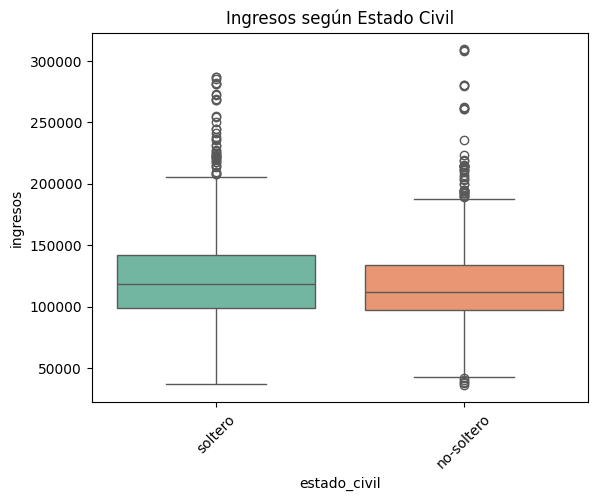

In [21]:
# Boxplot de ingresos por estado civil
sns.boxplot(x='estado_civil', y='ingresos', data=df,palette='Set2')
plt.title('Ingresos según Estado Civil')
plt.xticks(rotation=45)
plt.show()


Obersvando los diagramas de cajas, podemos ver que a primera vista el grupo de los solteros tienen una mediana mayor a la de los no-solteros. En este caso tenemos solo dos clases, de manera que podemos aplicar una prueba **t** para verificar la hipótesis de igualdad de medias o descartarla. Para esto, aplicaremos una prueba **t** de una cola, en la que se contrasta, para H0 si su valor promedio es menor. Para esta prueba **t** se asumirá que las varianzas de los grupos no son iguales. Esto último puede comprobarse, sin embargo, en este caso asumiremos la desiguladad.

In [22]:
# Test t de Student
soltero = df[df['estado_civil'] == 'soltero']['ingresos']
no_soltero = df[df['estado_civil'] == 'no-soltero']['ingresos']

t_stad, p_value = stats.ttest_ind(soltero, no_soltero, alternative='greater', equal_var=False)

if p_value < 0.05:
    print("Se rechaza la hipótesis nula: En promedio, los solteros tienen ingresos mayores.")
else:
    print("No se rechaza la hipótesis nula: En promedio, los solteros no tienen ingresos mayores.")

Se rechaza la hipótesis nula: En promedio, los solteros tienen ingresos mayores.


### CONCLUSIÓN HIPÓTESIS 3:
*El estado civil influye fuertemente en los ingresos. Existe evidencia estadística para concluir que, en promedio, Las personas solteras perciben ingresos superiores a los otros estados civiles.*

### HIPÓTESIS 4: La edad es un predictor del ingreso.


                            OLS Regression Results                            
Dep. Variable:               ingresos   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     262.2
Date:                Mon, 05 May 2025   Prob (F-statistic):           1.64e-55
Time:                        16:00:49   Log-Likelihood:                -23810.
No. Observations:                2000   AIC:                         4.762e+04
Df Residuals:                    1998   BIC:                         4.764e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.118e+04   2583.544     31.423      0.0

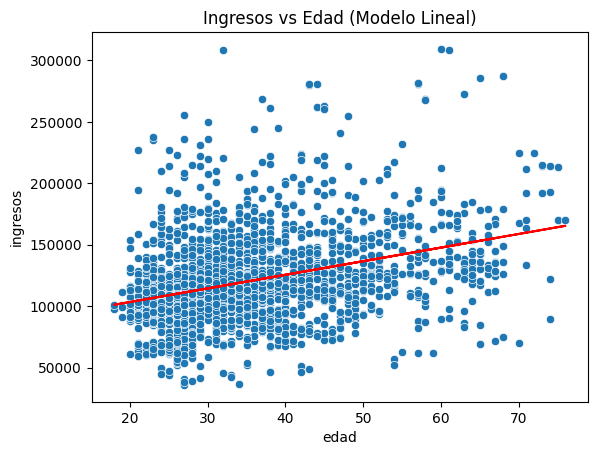

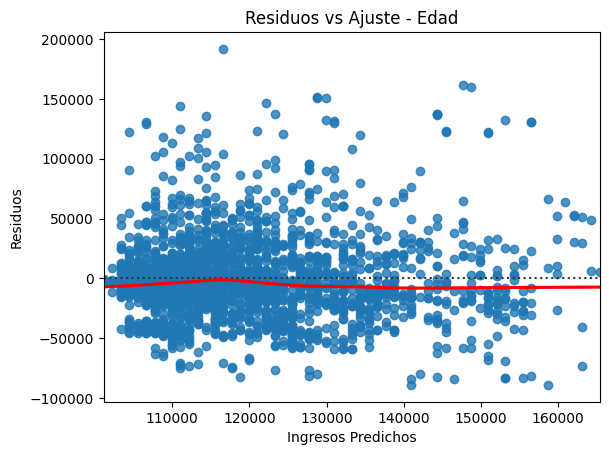

In [23]:
# Modelo 1: Ingresos ~ Edad
X = sm.add_constant(df['edad'])
y = df['ingresos']

modelo_edad = sm.OLS(y, X, missing='drop').fit()
print(modelo_edad.summary())

# Gráfico de ajuste
sns.scatterplot(x=df['edad'], y=df['ingresos'])
plt.plot(df['edad'], modelo_edad.predict(X), color='red')
plt.title('Ingresos vs Edad (Modelo Lineal)')
plt.show()

# Análisis de residuos
residuos = modelo_edad.resid
sns.residplot(x=modelo_edad.predict(X), y=residuos, lowess=True, line_kws={'color': 'red'})
plt.title('Residuos vs Ajuste - Edad')
plt.xlabel('Ingresos Predichos')
plt.ylabel('Residuos')
plt.show()

### CONCLUSIÓN HIPÓTESIS 4:

#### Modelo 1: Ingresos ~ Edad

***Resultados clave:***

***R²*** = 11.6% (modelo débil, pero significativo).

***Coeficiente Edad*** = (p < 0.0001).


### HIPÓTESIS 5
Diferencias de ingresos entre géneros en ocupaciones


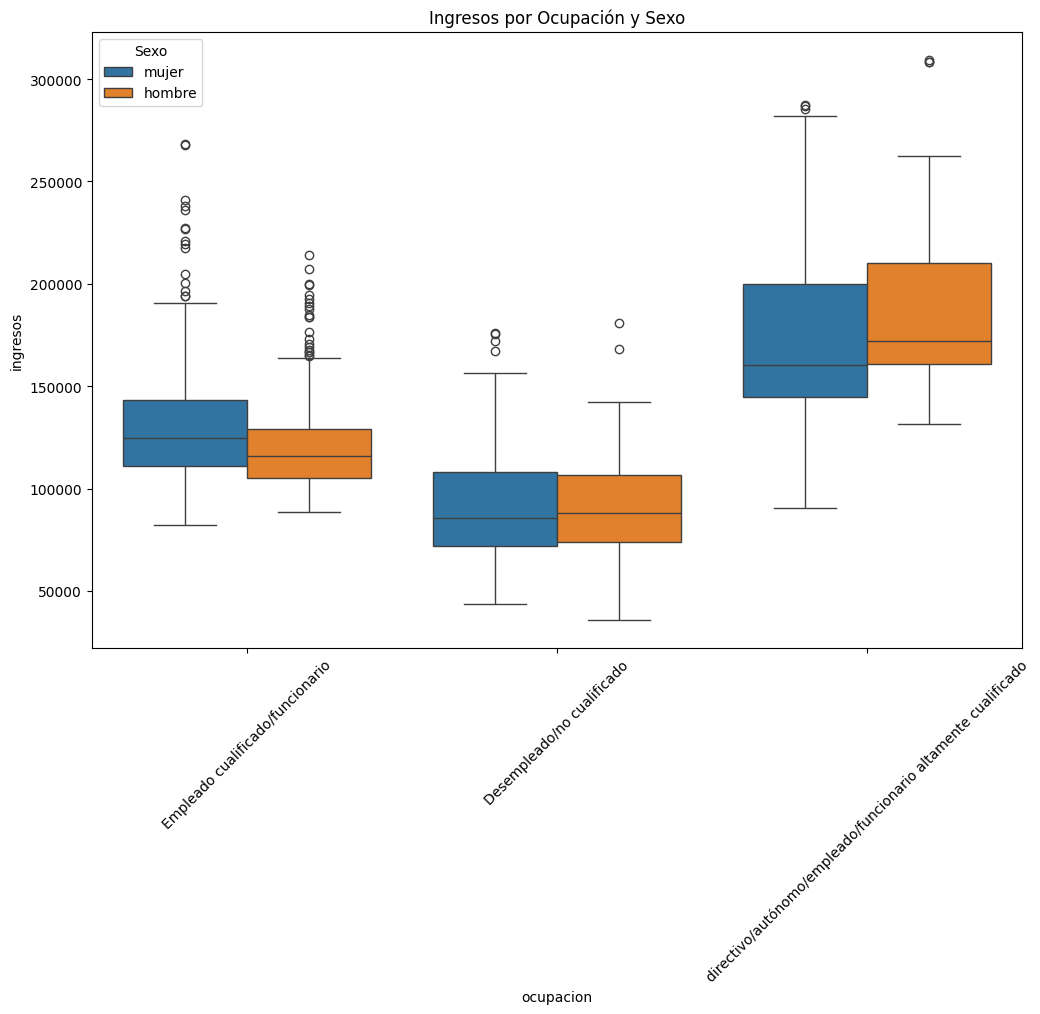

In [24]:
# Visualización: Ingresos por género en cada ocupación
plt.figure(figsize=(12,8))
sns.boxplot(x='ocupacion', y='ingresos', hue='sexo', data=df)
plt.title('Ingresos por Ocupación y Sexo')
plt.xticks(rotation=45)
plt.legend(title='Sexo')
plt.show()



Los gráficos de caja muestran la distribución de los ingresos por ocupación y género.
Se observa que los hombres tienden a tener ingresos más altos en casi todas las ocupaciones 
excepto en el el primer caso, donde las mujeres tienen ingresos más altos. Para corroborar
esto haremos una prueba de hipótesis para determinar si hay diferencias significativas en los ingresos
entre hombres y mujeres en cada ocupación.

Para hacerlo de forma automática, usamos un bucle for para iterar sobre cada ocupación, respecto de cada grupo de hombre y mujer, y realizamos la prueba t de Student, con la decisión en función del valor de prueba P, dado por el test, de forma automática tambien.

In [25]:
# Análisis estadístico específico (ocupación por ocupación)
ocupaciones = df['ocupacion'].unique()

for ocupacion in ocupaciones:
    subset = df[df['ocupacion'] == ocupacion]
    hombres = subset[subset['sexo'] == 'hombre']['ingresos']
    mujeres = subset[subset['sexo'] == 'mujer']['ingresos']
    
    if len(hombres) > 1 and len(mujeres) > 1:  # Evitar errores por grupos pequeños
        t_stat, p_val = stats.ttest_ind(hombres, mujeres, alternative="greater", equal_var=False)
        print(f'Ocupación: {ocupacion}')
        print(f'  T-test (hombres vs mujeres): t = {t_stat:.2f}, p = {p_val:.4f}')
        if p_val < 0.05:
            print(f'Se rechaza la hipótesis nula: En promedio los ingresos de hombres son superiores que los de mujeres.')
        else:
            print(f'No se rechaza la hipótesis nula: No hay evidencia suficiente para afirmar que los ingresos de los hombres son superiores a las mujeres.')
        print('------------------------------------------------')

Ocupación: Empleado cualificado/funcionario
  T-test (hombres vs mujeres): t = -6.20, p = 1.0000
No se rechaza la hipótesis nula: No hay evidencia suficiente para afirmar que los ingresos de los hombres son superiores a las mujeres.
------------------------------------------------
Ocupación: Desempleado/no cualificado
  T-test (hombres vs mujeres): t = -0.87, p = 0.8065
No se rechaza la hipótesis nula: No hay evidencia suficiente para afirmar que los ingresos de los hombres son superiores a las mujeres.
------------------------------------------------
Ocupación: directivo/autónomo/empleado/funcionario altamente cualificado
  T-test (hombres vs mujeres): t = 2.25, p = 0.0134
Se rechaza la hipótesis nula: En promedio los ingresos de hombres son superiores que los de mujeres.
------------------------------------------------


### CONCLUSIONES HIPÓTESIS 5 ###
*En algunas ocupaciones específicas, sí existen diferencias de ingreso por género, respaldando parcialmente la hipótesis.*

### CONCLUSIONES GENERALES:
- La educación, estado civil y la edad son factores importantes para el ingreso.

- Vivir en ciudades o asentamientos más grandes incrementa notablemente las oportunidades económicas.

- Existe desigualdad de género en ingresos, dependiendo de la ocupación.